In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager


from examples.fracture import configs
from examples.fracture.model import PINN

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})



In [3]:
cfg = configs.Config()
pinn = PINN(config=cfg)
ckpt = ocp.StandardCheckpointer()
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/state-of-the-art-0630-6k/model-6000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0629-state-of-the-art-4k/model-4000/") # alpha in loading is 3.0
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/baseline-long-train-50k/model-50000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0702-state-of-the-art-20k/model-20000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0702-baseline-causal-5k/model-5000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0702-baseline-causal-5k-2/model-5000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0704-baseline-causal_phi_t-5200/model-5000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0717-baseline-53load-4600/model-4600/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/717-irr_only_pf-no_causal/model-13000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0717-baseline-10k/model-10000/")
# state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/0722-baseline-7k/model-7000/")
state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/baseline-0924/model-7000/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/noirr/baseline-0924/model-7500/")

params = state["params"]
params_noirr = state_noirr["params"]

In [4]:
with open(f"{cfg.DATA_PATH}/force_disp.txt", "r") as f:
    lines = f.readlines()


def parse_line(line):
    line = line.strip().split("\t")
    line = [float(x) for x in line]
    return line
ref_force_disp = list(map(parse_line, lines))

# ref_force_disp = list(map(parse_line, lines))
# add 0, 0 at the beginning
ref_force_disp = [(0.0, 0.0)] + ref_force_disp
ref_force_disp = jnp.array(ref_force_disp)

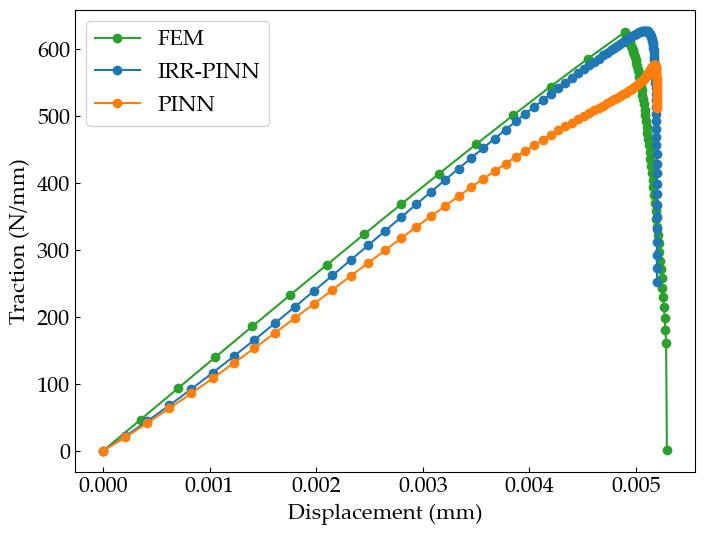

In [5]:
ts = jnp.linspace(0, 1, 101)
# mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
xs = jnp.linspace(-0.5, 0.5, 100)
ys = jnp.ones_like(xs) *(0.45)
top_mesh = jnp.stack([xs, ys], axis=1)
norm_vector = jnp.array([0, 1])

from jax.scipy import integrate

tractions = []
tractions_noirr = []
for idx, tic in enumerate(ts):
    t = jnp.ones_like(top_mesh[:, 0]) * tic
    t = t.reshape(-1, 1)
    # phi, disp = vmap(
    #     pinn.net_u, in_axes=(None, 0, 0)
    # )(params, top_mesh, t)

    sigma = jax.lax.stop_gradient(vmap(
        pinn.sigma, in_axes=(None, 0, 0)
    )(params, top_mesh, t))
    phi = jax.lax.stop_gradient(vmap(
        lambda params, x, t: pinn.net_u(params, x, t)[0], in_axes=(None, 0, 0)
    )(params, top_mesh, t)).squeeze()
    traction_vectors = jnp.einsum('ijk,k->ij', sigma, norm_vector)
    traction_normal = traction_vectors[:, 1] * (1 - phi)**2
    total_traction = integrate.trapezoid(traction_normal, xs)
    tractions.append(total_traction)

    sigma_noirr = jax.lax.stop_gradient(vmap(
        pinn.sigma, in_axes=(None, 0, 0)
    )(params_noirr, top_mesh, t))
    phi_noirr = jax.lax.stop_gradient(vmap(
        lambda params, x, t: pinn.net_u(params, x, t)[0], in_axes=(None, 0, 0)
    )(params_noirr, top_mesh, t)).squeeze()
    traction_vectors_noirr = jnp.einsum('ijk,k->ij', sigma_noirr, norm_vector)
    traction_normal_noirr = traction_vectors_noirr[:, 1] * (1 - phi_noirr)**2
    total_traction_noirr = integrate.trapezoid(traction_normal_noirr, xs)
    tractions_noirr.append(total_traction_noirr)

tractions = jnp.array(tractions)
%matplotlib inline
loading = cfg.loading(ts, alpha=4.0)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ref_force_disp[:, 0], ref_force_disp[:, 1], label="FEM", marker="o", color="C2")
ax.plot(loading, tractions, marker="o", label="IRR-PINN", color="C0")
ax.plot(loading, tractions_noirr, marker="o", label="PINN", color="C1")
ax.set(
    xlabel="Displacement (mm)",
    ylabel="Traction (N/mm)",
    # ylim=(0, 700),
)
ax.legend()
# plt.savefig("figures/fracture-t-disp.png", dpi=300, bbox_inches="tight")
# plt.savefig("figures/fracture-t-disp.pdf", dpi=300, bbox_inches="tight")

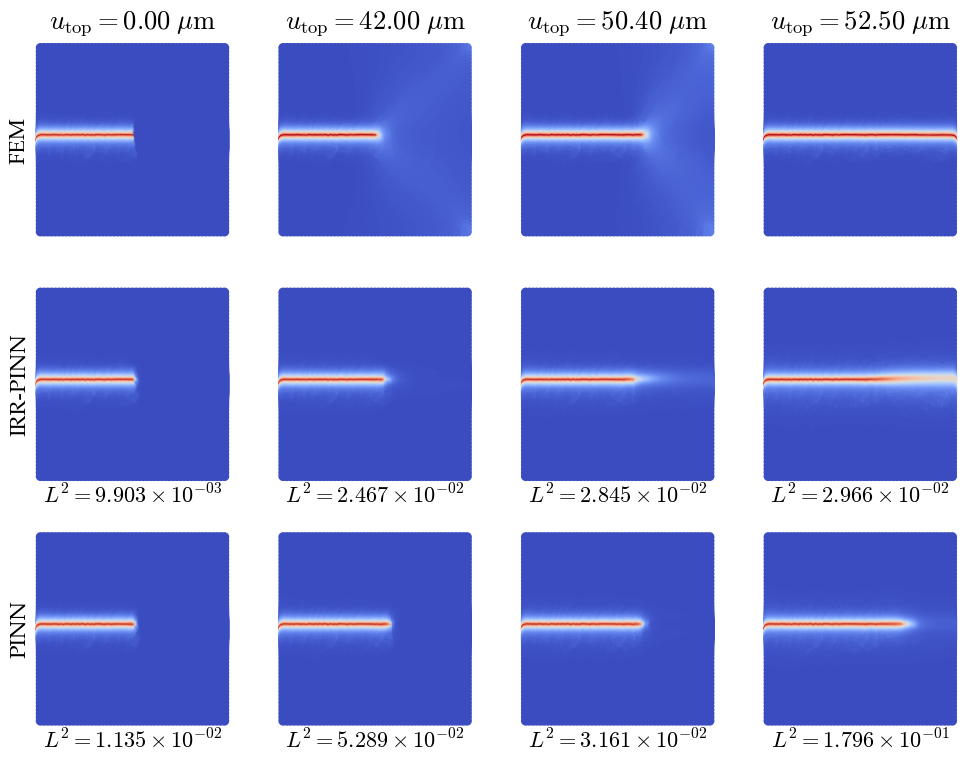

In [6]:
fem_ts = jnp.array([0.0000, 0.6000, 0.7200, 0.7500])
loadings = fem_ts * 0.007
pinn_ts = jnp.arctanh(jnp.clip(loadings * jnp.tanh(4.0) / cfg.UR, 0, 0.9993)) / 4.0


fig, axes = plt.subplots(3, len(fem_ts), figsize=(3 * len(fem_ts), 9))
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
for i in range(len(fem_ts)):
    pinn_time = pinn_ts[i]
    fem_time = fem_ts[i]
    loading = loadings[i]
    ref_sol = jnp.load(f"{cfg.DATA_PATH}/phi-{fem_time:.4f}.npy")
    ax = axes[0, i]
    ax.scatter(mesh[:, 0], mesh[:, 1], c=ref_sol, cmap="coolwarm", vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_aspect('equal', 'box')
    ax.set_title(f"$u_\\mathrm{{top}}={loading*10e3:.2f}\\;\\mathrm{{\\mu m}}$")
    # find positions near y=0
    # near_zero = jnp.isclose(mesh[:, 1], 0, atol=1e-2)
    # # find points phi < 0.5 along y=0 and the maximum x position
    # crack_tip_positions = mesh[(ref_sol > 0.5) & near_zero, 0]
    # max_x = jnp.max(crack_tip_positions)
    # crack_length = max_x + 0.5  # since the left boundary is at -0.5
    # ax.text(0.5, 0.05, f"{crack_length*cfg.Lc:.3f} mm", ha="center", va="bottom", transform=ax.transAxes,)

    ax = axes[1, i]
    phi, disp = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params, mesh, jnp.ones_like(mesh[:, 0]).reshape(-1, 1) * pinn_time)
    phi = phi.squeeze()
    error = jnp.linalg.norm(phi - ref_sol, 2) / jnp.linalg.norm(ref_sol, 2)
    error = error **2
    error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
    ax.text(0.5, 0., error_str, ha="center", va="top",transform=ax.transAxes)
    ax.scatter(mesh[:, 0], mesh[:, 1], c=phi, cmap="coolwarm", vmin=0, vmax=1)
    ax.set_aspect('equal', 'box')
    ax.set_axis_off()
    # xs = jnp.linspace(-0.5, 0.5, 100)
    # ys = jnp.ones_like(xs) *(0.0)
    # mesh_zero = jnp.stack([xs, ys], axis=1)
    # phi_zero, disp_zero = vmap(
    #     pinn.net_u, in_axes=(None, 0, 0)
    # )(params, mesh_zero, jnp.ones_like(mesh_zero[:, 0]).reshape(-1, 1) * pinn_time)
    # phi_zero = phi_zero.squeeze()
    # # find points phi < 0.5 along y=0 and the maximum x position
    # crack_tip_positions = mesh_zero[(phi_zero > 0.25), 0]
    # max_x = jnp.max(crack_tip_positions)
    # crack_length = max_x + 0.5  # since the left boundary is at -0.5
    # ax.text(0.5, 0.05, f"{crack_length*cfg.Lc:.3f} mm", ha="center", va="bottom", transform=ax.transAxes,)


    ax = axes[2, i]
    phi_noirr, disp_noirr = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params_noirr, mesh, jnp.ones_like(mesh[:, 0]).reshape(-1, 1) * pinn_time)
    ax.scatter(mesh[:, 0], mesh[:, 1], c=phi_noirr, cmap="coolwarm", vmin=0, vmax=1)
    phi_noirr = phi_noirr.squeeze()
    error = jnp.linalg.norm(phi_noirr - ref_sol, 2) / jnp.linalg.norm(ref_sol, 2)
    error = error **2
    error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
    ax.text(0.5, 0., error_str, ha="center", va="top",transform=ax.transAxes)
    ax.set_aspect('equal', 'box')
    ax.set_axis_off()

    if i == 0:
        ax = axes[0, i]
        ax.text(0.0, 0.5, "FEM", va="center", ha="right", rotation=90, transform=ax.transAxes)
        ax = axes[1, i]
        ax.text(0.0, 0.5, "IRR-PINN", va="center", ha="right", rotation=90, transform=ax.transAxes)
        ax = axes[2, i]
        ax.text(0.0, 0.5, "PINN", va="center", ha="right", rotation=90, transform=ax.transAxes)


# fig.tight_layout()
# fig.savefig("figures/fracture-phi.png", dpi=300, bbox_inches="tight")

In [7]:
epochs = jnp.arange(0, 7001, 500)
fem_ts = jnp.array([0.0000, 0.6000, 0.7200, 0.7500])
loadings = fem_ts * 0.007
pinn_ts = jnp.arctanh(jnp.clip(loadings * jnp.tanh(4.0) / cfg.UR, 0, 0.9993)) / 4.0
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc

error_log = []
error_log_noirr = []

@jit
def pred_phi(params, x_inp, t_inp):
    phi = vmap(
        lambda params, x, t: pinn.net_u(params, x, t)[0], in_axes=(None, 0, 0)
    )(params, x_inp, t_inp)
    return phi.squeeze()

for epoch in epochs:
    l2_norms = []
    l2_norms_noirr = []
    state = ckpt.restore(f"/root/autodl-tmp/tf-logs/fracture/irr/baseline-0924/model-{epoch}/")
    state_noirr = ckpt.restore(f"/root/autodl-tmp/tf-logs/fracture/noirr/baseline-0924/model-{epoch}/")
    params = state["params"]
    params_noirr = state_noirr["params"]
    for i in range(len(fem_ts)):
        ref_sol = jnp.load(f"{cfg.DATA_PATH}/phi-{fem_ts[i]:.4f}.npy")
        pinn_time = pinn_ts[i]
        phi = pred_phi(params, mesh, jnp.ones_like(mesh[:, 0]).reshape(-1, 1) * pinn_time)
        phi_noirr = pred_phi(params_noirr, mesh, jnp.ones_like(mesh[:, 0]).reshape(-1, 1) * pinn_time)
        error = jnp.linalg.norm(phi - ref_sol, 2) / jnp.linalg.norm(ref_sol, 2)
        error = error **2
        l2_norms.append(error)
        error_noirr = jnp.linalg.norm(phi_noirr - ref_sol, 2) / jnp.linalg.norm(ref_sol, 2)
        error_noirr = error_noirr **2
        l2_norms_noirr.append(error_noirr)
    l2_norms = jnp.array(l2_norms)
    l2_norms_noirr = jnp.array(l2_norms_noirr)
    error_log.append(jnp.mean(l2_norms))
    error_log_noirr.append(jnp.mean(l2_norms_noirr))

The final relative L2 error of IRR-PINN is 2.32e-02
The final relative L2 error of PINN is 7.28e-02
The minimum relative L2 error of IRR-PINN is 2.15e-02
The minimum relative L2 error of PINN is 6.76e-02


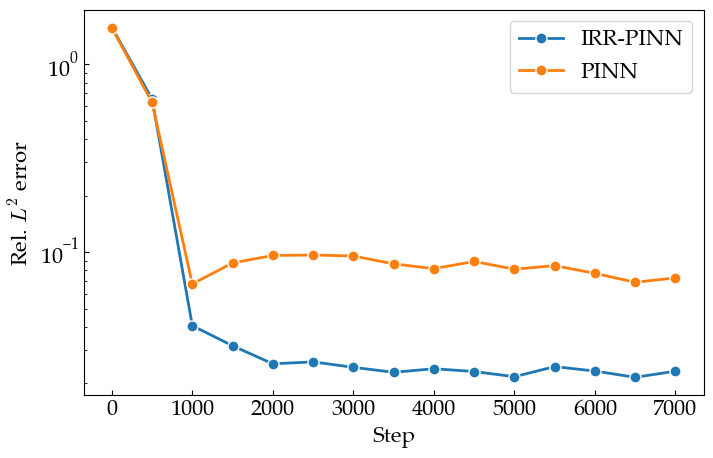

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(epochs, error_log, label="IRR-PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=8, markeredgewidth=1)
ax.plot(epochs, error_log_noirr, label="PINN", lw=2,
        marker="o", markeredgecolor="white", markersize=8, markeredgewidth=1)
ax.set(ylabel="Rel. $L^2$ error", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
# plt.savefig("figures/fracture-relerror-log.png", dpi=300, bbox_inches="tight")
# plt.savefig("figures/fracture-relerror-log.pdf", dpi=300, bbox_inches="tight")
print("The final relative L2 error of IRR-PINN is {:.2e}".format(error_log[-1]))
print("The final relative L2 error of PINN is {:.2e}".format(error_log_noirr[-1]))
print("The minimum relative L2 error of IRR-PINN is {:.2e}".format(jnp.min(jnp.array(error_log))))
print("The minimum relative L2 error of PINN is {:.2e}".format(jnp.min(jnp.array(error_log_noirr))))

In [9]:
mesh = jnp.load(pinn.cfg.DATA_PATH + "mesh_points.npy")
mesh.shape

(38687, 2)

(<Figure size 2000x1400 with 30 Axes>, (0, 0, 0))

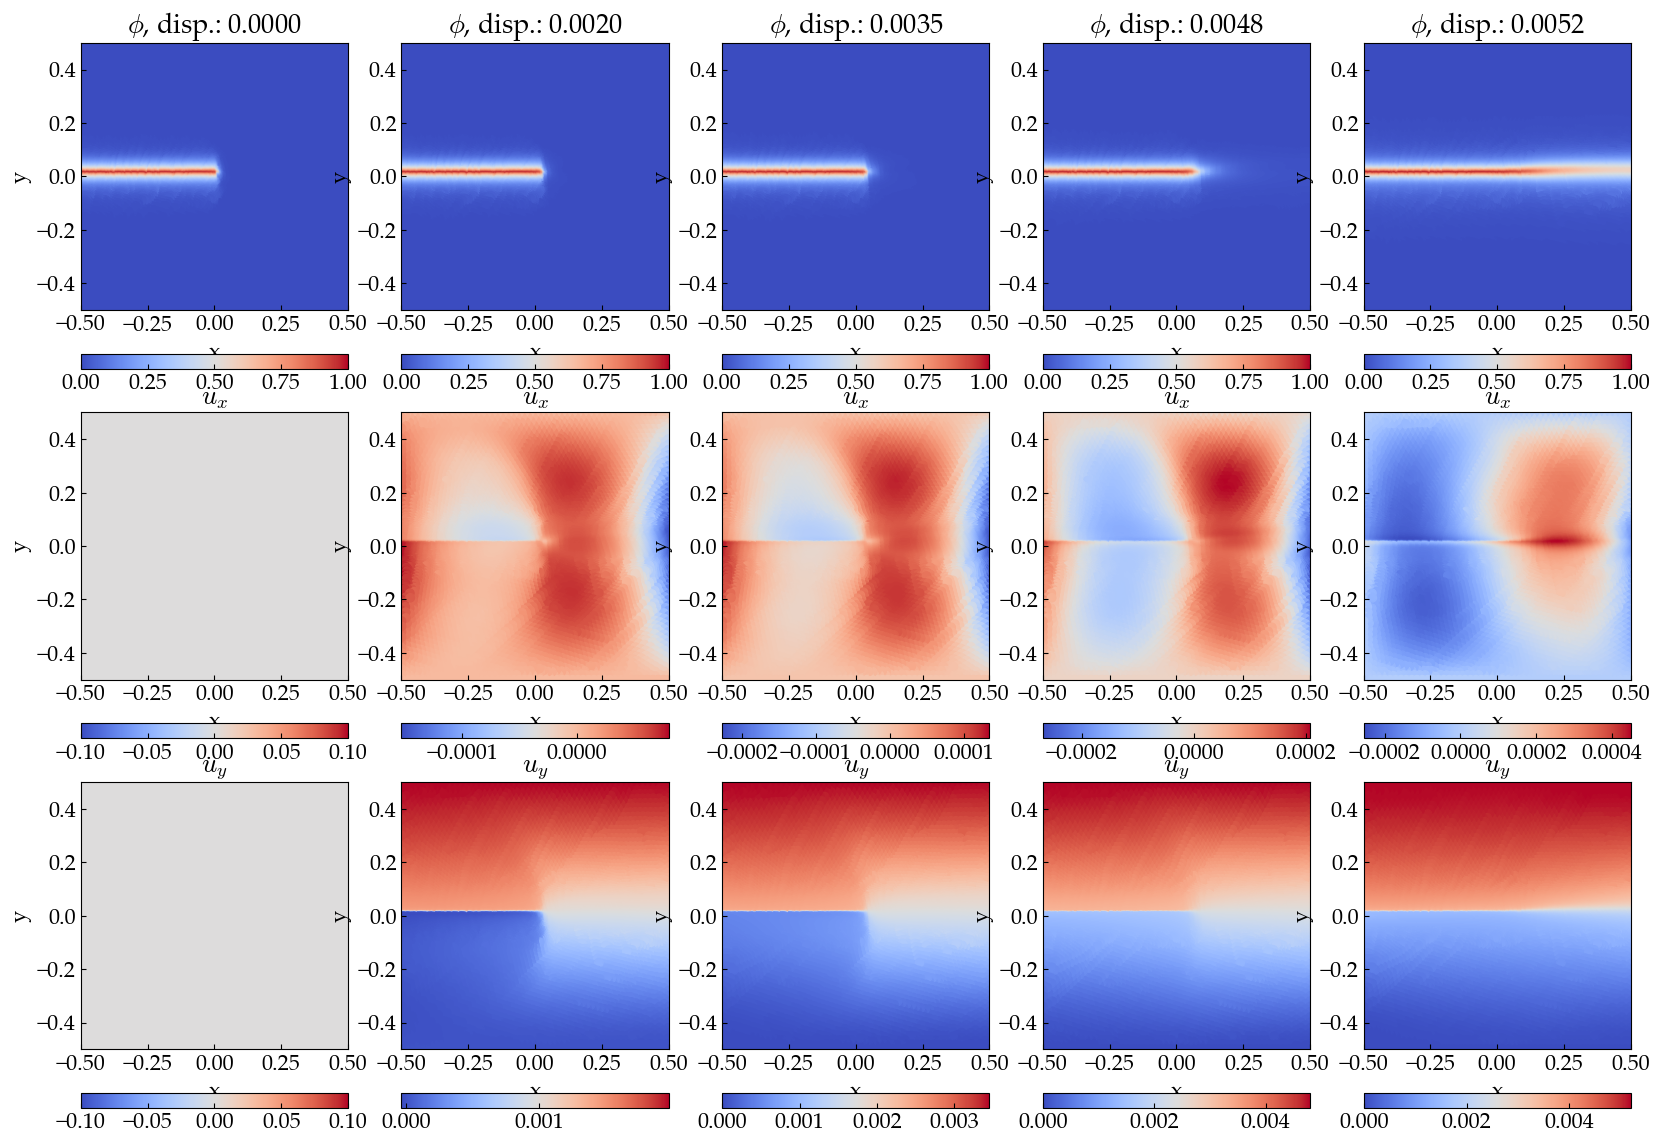

In [10]:
from examples.fracture.evaluator import evaluate2D
ts = [0.0, 0.1, 0.2, 0.4, 1.0]
evaluate2D(pinn, params, mesh, pinn.cfg.DATA_PATH, ts)
    
# plt.savefig("figures/fracture-sol.png", dpi=300, bbox_inches="tight")

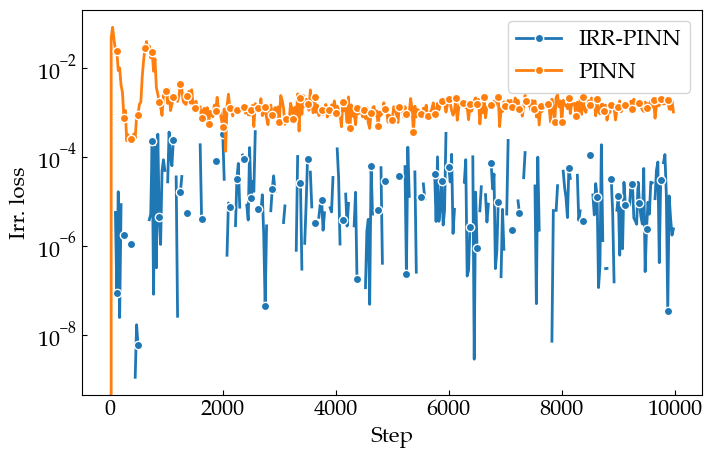

In [11]:
import pandas as pd
loss_log = pd.read_csv("./logs-eval/run-fracture_irr_0722-baseline-7k-tag-loss_irr.csv")
loss_log_noirr = pd.read_csv("./logs-eval/run-fracture_noirr_baseline2-tag-loss_irr.csv")


loss_log["Value"] = loss_log["Value"].apply(lambda x : jnp.nan if jnp.abs(x) < 1e-10 else x)
loss_log = loss_log[loss_log["Step"] < 10000]
loss_log_noirr = loss_log_noirr[loss_log_noirr["Step"] < 10000]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_log["Step"], loss_log["Value"], label="IRR-PINN", lw=2, markevery=5,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(loss_log_noirr["Step"], loss_log_noirr["Value"], label="PINN", lw=2, markevery=5,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
# plt.savefig("figures/fracture-irrloss-log.png", dpi=300, bbox_inches="tight")
# plt.savefig("figures/fracture-irrloss-log.pdf", dpi=300, bbox_inches="tight")

[Text(0.5, 0, 'Displacement (mm)'), Text(0, 0.5, 'Traction (N/mm)')]

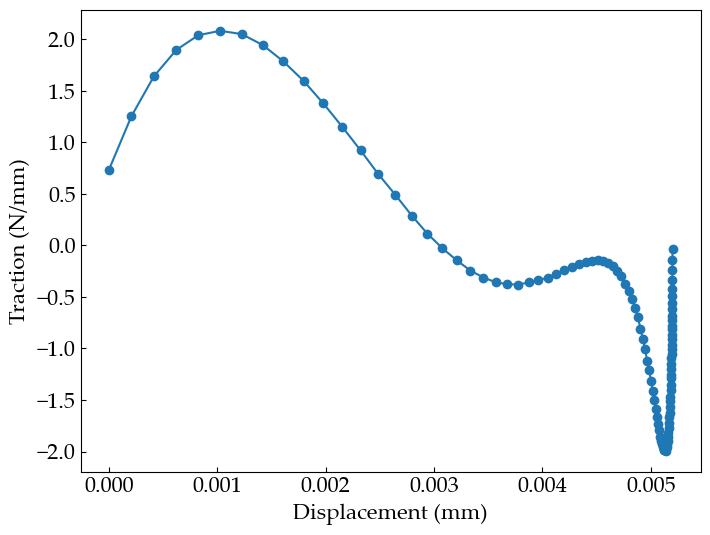

In [8]:
ts = jnp.linspace(0, 1, 101)
# mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
ys = jnp.linspace(-0.5, 0.5, 1000)
xs = jnp.ones_like(ys) * (0.5)
top_mesh = jnp.stack([xs, ys], axis=1)
norm_vector = jnp.array([1, 0])

tractions = []
for idx, tic in enumerate(ts):
    t = jnp.ones_like(top_mesh[:, 0]) * tic
    t = t.reshape(-1, 1)
    # phi, disp = vmap(
    #     pinn.net_u, in_axes=(None, 0, 0)
    # )(params, top_mesh, t)
    sigma = jax.lax.stop_gradient(vmap(
        pinn.sigma, in_axes=(None, 0, 0)
    )(params, top_mesh, t))

    phi = jax.lax.stop_gradient(vmap(
        lambda params, x, t: pinn.net_u(params, x, t)[0], in_axes=(None, 0, 0)
    )(params, top_mesh, t)).squeeze()

    traction_vectors = jnp.einsum('ijk,k->ij', sigma, norm_vector)
    traction_normal = traction_vectors[:, 0] * (1 - phi)**2
    total_traction = integrate.trapezoid(traction_normal, ys)
    tractions.append(total_traction)

tractions = jnp.array(tractions)
%matplotlib inline
loading = cfg.loading(ts)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loading, tractions, label="traction", marker="o",)
ax.set(
    xlabel="Displacement (mm)",
    ylabel="Traction (N/mm)",
)



In [9]:
sigma.shape

(1000, 2, 2)

Text(0.5, 0.98, 'x=0.0, loading=0.0052')

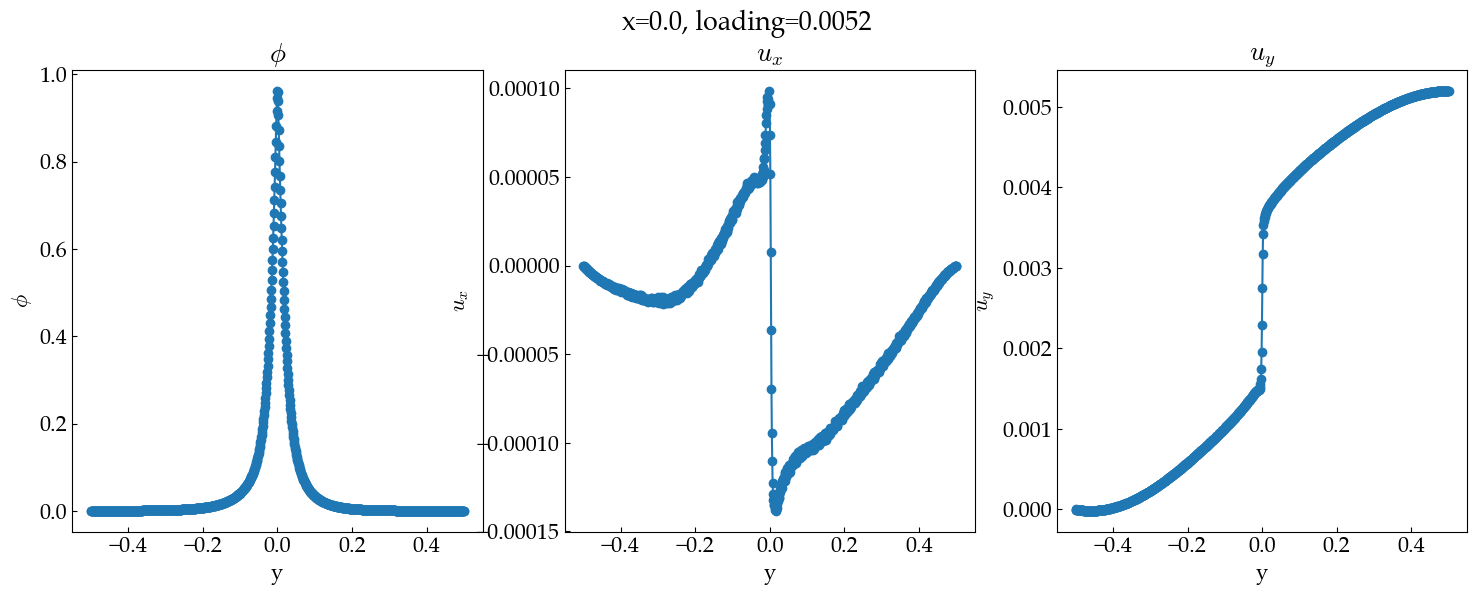

In [33]:
ys = jnp.linspace(-0.5, 0.5, 1000)
xs = jnp.ones_like(ys) * (-0.5)
slice_mesh = jnp.stack([xs, ys], axis=1)
tic = 1.0
t = jnp.ones_like(slice_mesh[:, 0]) * tic
t = t.reshape(-1, 1)
phi, disp = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, slice_mesh, t)
disp_loading = cfg.loading(tic)

# fig, ax = plt.subplots(figsize=(6, 4))
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax = axes[0]
ax.plot(ys, phi, label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel=r"$\phi$",
    title=r"$\phi$",
)

ax = axes[1]
ax.plot(ys, disp[:, 0], label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel=r"$u_x$",
    title=r"$u_x$",
)

ax = axes[2]
ax.plot(ys, disp[:, 1], label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel=r"$u_y$",
    title=r"$u_y$",
)


fig.suptitle(f"x=0.0, loading={disp_loading:.4f}")

Text(0.5, 0.98, 'x=0.0, loading=0.0052')

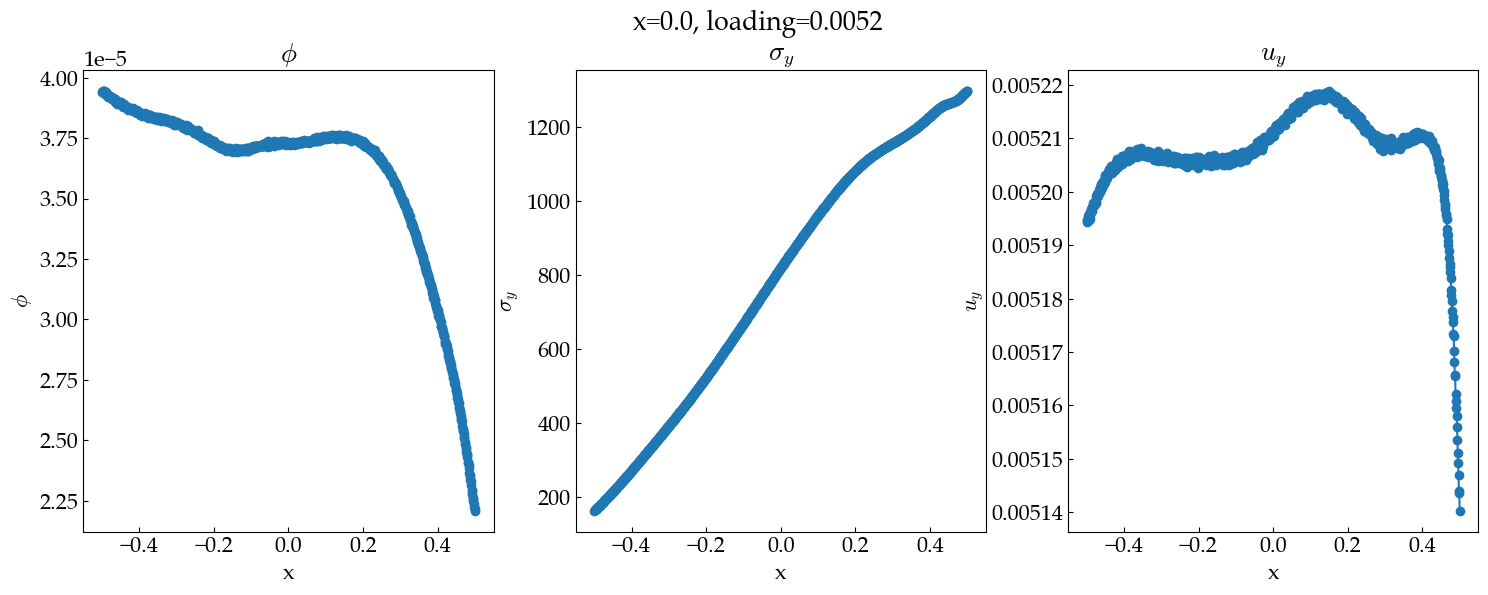

In [14]:
xs = jnp.linspace(-0.5, 0.5, 1000)
ys = jnp.ones_like(ys) * (0.5)
slice_mesh = jnp.stack([xs, ys], axis=1)
tic = 1.0
t = jnp.ones_like(slice_mesh[:, 0]) * tic
t = t.reshape(-1, 1)
phi, disp = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, slice_mesh, t)
phi = phi.squeeze()

sigma = jax.lax.stop_gradient(vmap(
    pinn.sigma, in_axes=(None, 0, 0)
)(params, slice_mesh, t))
tractions = jnp.einsum('ijk,k->ij', sigma, jnp.array([0, 1]))
traction_normal = tractions[:, 1] * (1 - phi)**2

disp_loading = cfg.loading(tic)

# fig, ax = plt.subplots(figsize=(6, 4))
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax = axes[0]
ax.plot(xs, phi, label="displacement", marker="o",)
ax.set(
    xlabel="x",
    ylabel=r"$\phi$",
    title=r"$\phi$",
)

ax = axes[1]
ax.plot(xs, traction_normal, label="displacement", marker="o",)
ax.set(
    xlabel="x",
    ylabel=r"$\sigma_y$",
    title=r"$\sigma_y$",
)

ax = axes[2]
ax.plot(xs, disp[:, 1], label="displacement", marker="o",)
ax.set(
    xlabel="x",
    ylabel=r"$u_y$",
    title=r"$u_y$",
)


fig.suptitle(f"x=0.0, loading={disp_loading:.4f}")

In [31]:
tractions[:, 1].shape

(1000,)

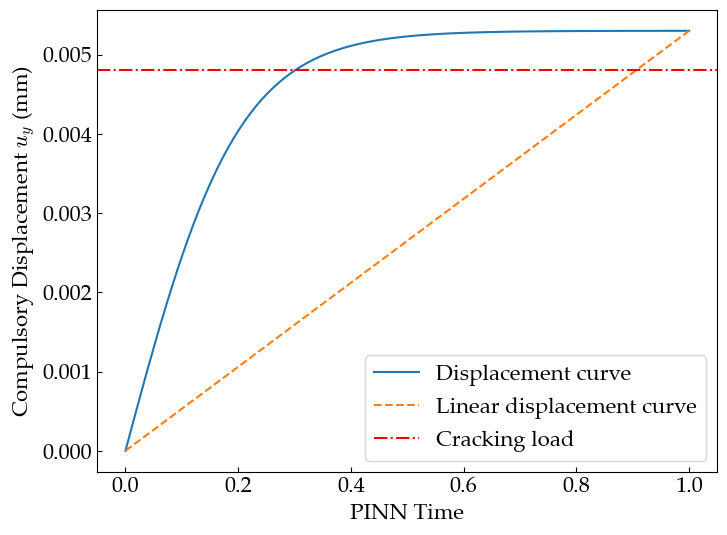

In [32]:
%matplotlib inline

t = jnp.linspace(0, 1, 100)
# load = cfg.loading(t)



def loading_fn(t, alpha=5, ):
    # return cls.UR * t
    return 0.0053 / jax.nn.tanh(alpha) * jax.nn.tanh(alpha* t)
    # return 0.006 / jnp.log(alpha+1) * jnp.log(alpha*t+1)
    # return jnp.where(t<0.1, 0.005 / 0.1*t, (0.006-0.005) / 0.9*(t - 0.1) + 0.005)
load = loading_fn(t)
load_linear = t * 0.0053
cracking_load = 0.0048

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, load, label="Displacement curve",)
ax.plot(t, load_linear, label="Linear displacement curve", linestyle="--")
ax.axhline(cracking_load, color="red", linestyle="-.", label="Cracking load")
ax.set(xlabel="PINN Time", ylabel="Compulsory Displacement $u_y$ (mm)")
ax.legend()

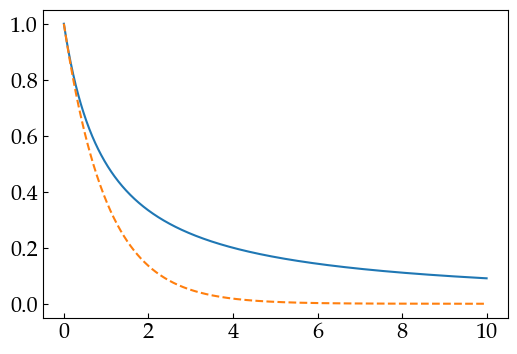

In [12]:
%matplotlib inline
x = jnp.linspace(0, 10, 1000)
y1 = 1 / (1 + x)
y2 = jnp.exp(-x)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y1, label="1 / (1 + x)",)
ax.plot(x, y2, label="exp(-x)", linestyle="--")

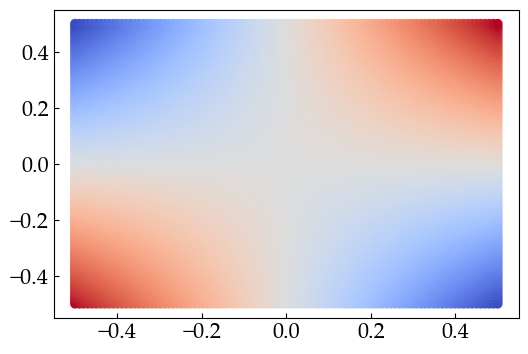

In [13]:
xs = jnp.linspace(-0.5, 0.5, 100)
ys = jnp.linspace(-0.5, 0.5, 100)
xs, ys = jnp.meshgrid(xs, ys)
mesh = jnp.stack([xs, ys], axis=-1)
mesh = mesh.reshape(-1, 2)
xs, ys = jnp.split(mesh, 2, axis=-1)
phi = xs * ys

# phi = jnp.exp(-jnp.abs(ys) / 0.015) * jax.nn.sigmoid(-xs * 100)
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(xs, ys, c=phi, cmap="coolwarm")